In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
from google.colab import drive
from torch.utils.data import Dataset
import copy
from torchvision.transforms import RandomAffine, RandomRotation, CenterCrop, Resize
import matplotlib.pyplot as plt
import random
from torch.autograd import Variable

# Data Loading

In [ ]:
drive.mount("/content/drive")
%cd /content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py


In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

def constructimage(data):
  images = data.reshape((len(data), 3,32,32))
  return images

In [ ]:
class data_set(Dataset):
  def __init__(self, filelocation, test = False):
    if not test:
      labels = np.zeros(50000)
      data = np.zeros((50000,3,32,32))
      for i in range(1,6):
        batch = unpickle(filelocation + str(i))
        images = constructimage(batch[b'data'])
        data[10000*(i-1):10000*i,:,:,:] = images
        labels[10000*(i-1):10000*i] = batch[b'labels']
    if test:
      batch = unpickle("test_batch")
      data = constructimage(batch[b'data'])
      labels = batch[b'labels']

    self.data = data
    self.label = labels

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return self.data[index], self.label[index]

In [ ]:
dataset_train = data_set("data_batch_")
dataset_test = data_set("test_batch", test=True)

# Model Training

In [ ]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("current device: ", device)

current device:  cuda


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=10)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=10)

In [ ]:
model = CIFAR10CNN()
model.to(device)
num_epochs = 30
# Loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model.train()
loss_avg = []
# Train the model
for epoch in range(num_epochs):
    epoch_loss = 0.0
    count = 0

    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.float()
        labels = labels.long()
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_function(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        epoch_loss += loss.item()
        count += 1

    # Calculate the average loss for the epoch
    avg = epoch_loss / count
    loss_avg.append(avg)

    print(f'Epoch {epoch+1}, Loss: {avg:.4f}')

Epoch 1, Loss: 1.2183
Epoch 2, Loss: 0.7910
Epoch 3, Loss: 0.6010
Epoch 4, Loss: 0.4530
Epoch 5, Loss: 0.3235
Epoch 6, Loss: 0.2358
Epoch 7, Loss: 0.1833
Epoch 8, Loss: 0.1394
Epoch 9, Loss: 0.1105
Epoch 10, Loss: 0.0856
Epoch 11, Loss: 0.0667
Epoch 12, Loss: 0.0497
Epoch 13, Loss: 0.0438
Epoch 14, Loss: 0.0355
Epoch 15, Loss: 0.0251
Epoch 16, Loss: 0.0224
Epoch 17, Loss: 0.0193
Epoch 18, Loss: 0.0139
Epoch 19, Loss: 0.0078
Epoch 20, Loss: 0.0046
Epoch 21, Loss: 0.0020
Epoch 22, Loss: 0.0005
Epoch 23, Loss: 0.0002
Epoch 24, Loss: 0.0001
Epoch 25, Loss: 0.0001
Epoch 26, Loss: 0.0001
Epoch 27, Loss: 0.0001
Epoch 28, Loss: 0.0001
Epoch 29, Loss: 0.0001
Epoch 30, Loss: 0.0001


In [ ]:
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.float()
      labels = labels.long()
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      del images, labels, outputs

  print('Test Accuracy: {} %'.format(100 * correct / total))

Test Accuracy: 82.15 %


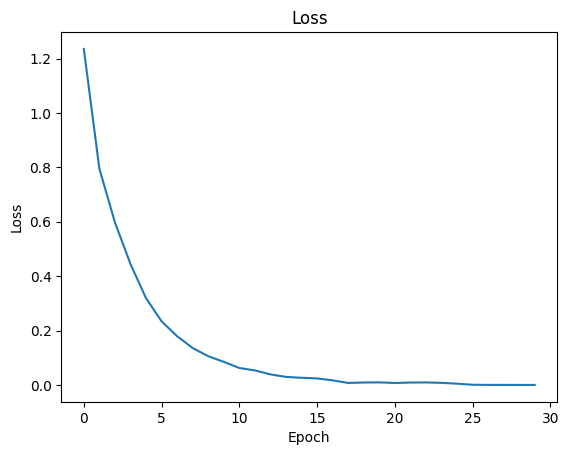

In [ ]:
# Plotting the epoch-wise average loss
plt.plot(loss_avg)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

In [ ]:
torch.save(model.state_dict(),"./trained_CNN.pth")

# Attack Model

In [ ]:
trained_CNN = CIFAR10CNN()
# trained_CNN.load_state_dict(torch.load("./trained_CNN.pth",map_location=torch.device('cpu'))) #map_location=torch.device('cpu')
trained_CNN.load_state_dict(torch.load("./trained_CNN.pth"))
trained_CNN.to(device)

CIFAR10CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_feat

##FGSM Attack

In [ ]:
# FGSM attack function
loss_function = nn.CrossEntropyLoss()
def fgsm_attack(model, x, y_true, epsilon):
    x.requires_grad = True
    outputs = model(x)
    loss = loss_function(outputs, y_true)
    model.zero_grad()
    loss.backward()
    perturbed_image = x + epsilon * x.grad.detach().sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Evaluate model accuracy under FGSM attack for different epsilon values
epsilons = [0.001, 0.05, 0.1]
for epsilon in epsilons:
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.float()
      labels = labels.long()
      images = images.to(device)
      labels = labels.to(device)
      y_true = labels
      perturbed_images = fgsm_attack(trained_CNN, images, y_true, epsilon)
      outputs = trained_CNN(perturbed_images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy under FGSM attack with epsilon={epsilon}: {accuracy}%')
    del perturbed_images, labels, outputs


Accuracy under FGSM attack with epsilon=0.001: 10.64%
Accuracy under FGSM attack with epsilon=0.05: 10.58%
Accuracy under FGSM attack with epsilon=0.1: 10.53%


##PGD Attack

In [ ]:
def pgd_attack(model, x, y_true, epsilon, alpha, num_iter):
    perturbed_image = x.clone().detach()
    perturbed_image.requires_grad = True
    perturbed_image2 = perturbed_image.clone().detach()

    for _ in range(num_iter):
        outputs = model(perturbed_image)
        loss = loss_function(outputs, y_true)
        model.zero_grad()
        loss.backward()

        perturbed_image2 += alpha * perturbed_image.grad.sign()
        perturbed_image2 = torch.max(torch.min(perturbed_image2, x + epsilon), x - epsilon).detach_()
        perturbed_image2 = torch.clamp(perturbed_image2, 0, 1)

    return perturbed_image2

# Evaluate model accuracy under PGD attack for different epsilon values
epsilons = [0.01, 0.05, 0.1]
for epsilon in epsilons:
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.float()
      labels = labels.long()
      images = images.to(device)
      labels = labels.to(device)
      y_true = labels
      perturbed_images = pgd_attack(trained_CNN, images, y_true, epsilon, alpha=0.01, num_iter=10)
      outputs = trained_CNN(perturbed_images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy under PGD attack with epsilon={epsilon}: {accuracy}%')
    del perturbed_images, labels, outputs

Accuracy under PGD attack with epsilon=0.01: 10.65%
Accuracy under PGD attack with epsilon=0.05: 10.58%
Accuracy under PGD attack with epsilon=0.1: 10.53%


#Defense Model with FGSM Attack


In [ ]:
model_def = CIFAR10CNN()
model_def = model_def.to(device)
model_def = nn.DataParallel(model_def)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_def.parameters(), lr=0.05, momentum=0.8, weight_decay=0.0002)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=40)
num_epochs = 80

model_def.train()
loss_avg = []
# Train the model
for epoch in range(num_epochs):
    epoch_loss = 0.0
    count = 0

    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.float()
        labels = labels.long()
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        x_adv = fgsm_attack(model_def, images, labels, epsilon=0.001)
        # Forward pass
        outputs = model_def(x_adv)
        loss = loss_function(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accumulate the loss
        epoch_loss += loss.item()
        count += 1

    # Calculate the average loss for the epoch
    avg = epoch_loss / count
    loss_avg.append(avg)

    print(f'Epoch {epoch+1}, Loss: {avg:.4f}')


Epoch 1, Loss: 2.2744
Epoch 2, Loss: 2.2501
Epoch 3, Loss: 2.2339
Epoch 4, Loss: 2.2172
Epoch 5, Loss: 2.2017
Epoch 6, Loss: 2.1829
Epoch 7, Loss: 2.1646
Epoch 8, Loss: 2.1410
Epoch 9, Loss: 2.1156
Epoch 10, Loss: 2.0864
Epoch 11, Loss: 2.0558
Epoch 12, Loss: 2.0259
Epoch 13, Loss: 1.9933
Epoch 14, Loss: 1.9655
Epoch 15, Loss: 1.9405
Epoch 16, Loss: 1.9133
Epoch 17, Loss: 1.8884
Epoch 18, Loss: 1.8701
Epoch 19, Loss: 1.8512
Epoch 20, Loss: 1.8360
Epoch 21, Loss: 1.8184
Epoch 22, Loss: 1.8118
Epoch 23, Loss: 1.7935
Epoch 24, Loss: 1.7920
Epoch 25, Loss: 1.7831
Epoch 26, Loss: 1.7763
Epoch 27, Loss: 1.7707
Epoch 28, Loss: 1.7622
Epoch 29, Loss: 1.7597
Epoch 30, Loss: 1.7503
Epoch 31, Loss: 1.7539
Epoch 32, Loss: 1.7512
Epoch 33, Loss: 1.7454
Epoch 34, Loss: 1.7373
Epoch 35, Loss: 1.7434
Epoch 36, Loss: 1.7389
Epoch 37, Loss: 1.7408
Epoch 38, Loss: 1.7346
Epoch 39, Loss: 1.7334
Epoch 40, Loss: 1.7334
Epoch 41, Loss: 1.7353
Epoch 42, Loss: 1.7331
Epoch 43, Loss: 1.7337
Epoch 44, Loss: 1.72

In [ ]:
correct = 0
total = 0
for images, labels in test_loader:
    images = images.float()
    labels = labels.long()
    images = images.to(device)
    labels = labels.to(device)
    x_adv = fgsm_attack(model_def, images, labels, epsilon=0.1)
    outputs = model_def(x_adv)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    del images, labels, outputs

print('Test Accuracy: {} %'.format(100 * correct / total))

Test Accuracy: 13.41 %


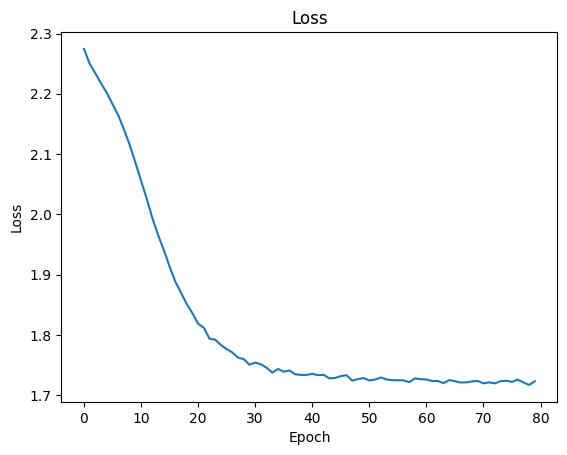

In [ ]:
# Plotting the epoch-wise average loss
plt.plot(loss_avg)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()